<a href="https://colab.research.google.com/github/HoseinNekouei/US_Airline_Sentiment_Classification/blob/main/pyTorch_US_airline_kfold_version.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import Libreries and important requirment**

In [ ]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 487.4/487.4 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 18.3 MB/s eta 0:00:00


In [ ]:
import os
import gc
import pandas as pd
from google.colab import output

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
!mkdir /content/dataset
!cp /content/drive/MyDrive/Projects/Sentiment_Analysis/Augmented_dataset_US_airline_Tweet.csv /content/dataset

mkdir: cannot create directory ‘/content/dataset’: File exists


# **Load Dataset and Pre-Processing data**

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

class DataVisualizer:
    @staticmethod
    def visualize_sentiment(data):
        sentiment_count = data.airline_sentiment.value_counts()
        colors = sns.color_palette('pastel', 3)
        labels = ['Negative', 'Neutral', 'Positive']
        explode = [0.01, 0.01, 0.01]

        plt.figure(figsize=(4, 4))
        sentiment_count.plot(
            kind='pie',
            colors=colors,
            labels=labels,
            explode=explode,
            shadow=True,
            autopct='%.2f',
            fontsize=12,
        )
        plt.title('Total Tweets for Each Sentiment')
        plt.ylabel(' ')
        plt.show()

In [ ]:
import logging
import string
import re
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')

class TextProcessor:
    @staticmethod
    def class_mapping(sentiment: str)-> int:
        """ Map class labels to new values."""

        if sentiment== 'negative':
          return 0
        elif sentiment== 'neutral':
          return 1
        elif sentiment== 'positive':
          return 2
        else:
          logging.warning(f'Unknown Sentiment {sentiment}')
          return -1

    # Remove url
    @staticmethod
    def remove_urls(text):
        url = re.compile(r'https?://\S+|www\.\S+')
        return url.sub(r'',text)

    # Remove html
    @staticmethod
    def remove_html(text):
        html=re.compile(r'<.*?>')
        return html.sub(r'',text)

    # Decontraction text
    @staticmethod
    def decontraction(text):
        text = re.sub(r"won\'t", " will not", text)
        text = re.sub(r"won\'t've", " will not have", text)
        text = re.sub(r"can\'t", " can not", text)
        text = re.sub(r"don\'t", " do not", text)
        text = re.sub(r"didn\'t", " did not", text)
        text = re.sub(r"can\'t've", " can not have", text)
        text = re.sub(r"ma\'am", " madam", text)
        text = re.sub(r"let\'s", " let us", text)
        text = re.sub(r"ain\'t", " am not", text)
        text = re.sub(r"shan\'t", " shall not", text)
        text = re.sub(r"sha\n't", " shall not", text)
        text = re.sub(r"o\'clock", " of the clock", text)
        text = re.sub(r"y\'all", " you all", text)
        text = re.sub(r"n\'t", " not", text)
        text = re.sub(r"n\'t've", " not have", text)
        text = re.sub(r"\'re", " are", text)
        text = re.sub(r"\'s", " is", text)
        text = re.sub(r"\'d", " would", text)
        text = re.sub(r"\'d've", " would have", text)
        text = re.sub(r"\'ll", " will", text)
        text = re.sub(r"\'ll've", " will have", text)
        text = re.sub(r"\'t", " not", text)
        text = re.sub(r"\'ve", " have", text)
        text = re.sub(r"\'m", " am", text)
        text = re.sub(r"\'re", " are", text)
        return text

    @staticmethod
    def normalize_repeated_chars(text):
        # Step 1: Preserve ellipses by temporarily replacing them with a unique placeholder
        placeholder = "<ELLIPSIS>"
        text = re.sub(r'\.{3,}', placeholder, text)  # Replace ellipses with a placeholder

        # Step 2: Normalize repeated characters. Matches any character repeated 3 or more times like cooool -> cool
        text = re.sub(r'(.)\1{2,}', r'\1', text)

        # Step 3: Restore ellipses by replacing the placeholder with '...'
        text = text.replace(placeholder, '...')
        return text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
from typing import Optional

class DatasetLoader:
    def __init__(self, *, file_path: str):
        self.file_path: str = file_path
        self._data: Optional[pd.DataFrame] = None

    def loader(self) -> None:
        if not os.path.exists(self.file_path):
            raise FileNotFoundError(f"File not found: {self.file_path}")
        self._data = pd.read_csv(self.file_path)

    def visualize_data(self):
        if self._data is not None:
            DataVisualizer.visualize_sentiment(self._data)
        else:
            raise ValueError("Data not loaded. Call `loader()` first.")

    def map_classes(self):
        if self._data is not None:
            # Apply the static method to map classes
            self._data['labels']= self._data['airline_sentiment'].apply(TextProcessor.class_mapping)
        else:
            raise ValueError("Data not loaded. Call `loader()` first.")

    def text_preprocessing(self):
        if self._data is not None:
            # Apply the static method to remove html
            self._data['revised_text']= self._data['text'].apply(TextProcessor.remove_html)

            # Apply the static method to remove urls
            self._data['revised_text']= self._data['revised_text'].apply(TextProcessor.remove_urls)

            # Apply the static method to decontract text.
            self._data['revised_text']= self._data['revised_text'].apply(TextProcessor.decontraction)

            # Convert texts to lowercase.
            self._data['revised_text']= self._data['revised_text'].apply(lambda x: x.lower())

            # Replace Repeated Characters with a Single Instance
            self._data['revised_text']= self._data['revised_text'].apply(TextProcessor.normalize_repeated_chars)

        else:
            raise ValueError("Data not loaded. Call 'loader()' first")

    def __str__(self):
        if self._data is None:
            return "Data not loaded."
        information = [
            f'Categories of : {self._data.airline_sentiment.value_counts().to_dict()}',
            f'\nInformation: {self._data.info()}'
        ]
        return ', '.join(information)

    def __call__(self):
        self.loader()
        self.visualize_data()
        self.map_classes()
        self.text_preprocessing()


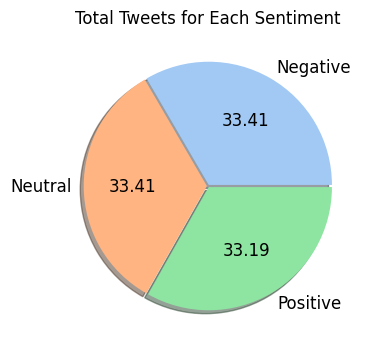

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54231 entries, 0 to 54230
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   text               54231 non-null  object
 1   airline_sentiment  54231 non-null  object
 2   negativereason     18117 non-null  object
 3   positivereason     17997 non-null  object
 4   labels             54231 non-null  int64 
 5   revised_text       54231 non-null  object
dtypes: int64(1), object(5)
memory usage: 2.5+ MB
Categories of : {'neutral': 18117, 'negative': 18117, 'positive': 17997}, 
Information: None


In [ ]:
file_path= '/content/dataset/Augmented_dataset_US_airline_Tweet.csv'
loader= DatasetLoader(file_path= file_path)
loader()

print(loader)

# **Load Model and make new augmented dataset of X_train**

In [ ]:
from transformers import T5ForConditionalGeneration, T5TokenizerFast

flan_model_name= "google/flan-t5-large"
# flan_model_name= "google/flan-t5-xxl"

flan_model= T5ForConditionalGeneration.from_pretrained(flan_model_name, device_map='auto', torch_dtype= torch.float16)
flan_tokenizer= T5TokenizerFast.from_pretrained(flan_model_name)

config.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.13G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

In [ ]:
def tweet_augmentation(tweets, batch_size= 32):
    # Define a prompt
    prompt= 'Provide a brief explanation the interpretation of the key emotional aspects and tone: '
    augmented_tweets= []

    for i in range(0, len(tweets), batch_size):
        batch= tweets[i: i+ batch_size]
        prompts= [prompt + tweet  for tweet in batch]

        #Tokenize and generate
        inputs= flan_tokenizer(
            prompts,
            return_tensors= 'pt',
            padding= True,
            truncation= True).to(device)

        outputs= flan_model.generate(
            **inputs,
            max_length= 50,
            num_return_sequences=1,)
            # num_beams= 5,
            # early_stopping=True)

        #Decode and combine
        generated_tweets= flan_tokenizer.batch_decode(outputs, skip_special_tokens= True)

        output.clear()
        print(f'generate {i}/{len(tweets)} tweets')

        for original_tweet, generated_tweet in zip(batch, generated_tweets):
            augmented_tweets.append(f"{original_tweet} [START_ASPECT] {generated_tweet} [END_ASPECT]")

    return augmented_tweets

augmented_X_train= tweet_augmentation(loader._data['revised_text'], batch_size= 512)

generate 40448/40673 tweets


In [ ]:
from datasets import Dataset
# Create a Hugging Face Dataset
train_corpus = Dataset.from_dict({
    "text": augmented_X_train,
    "labels": y_train
})

train_data= pd.DataFrame(augmented_dataset)
train_data.to_csv("/content/drive/MyDrive/Projects/Sentiment_Analysis/twitter_train_corpus.csv", index=False)

train_data['text'][0], train_data['labels'][0]

('@united i  did not get a message from you. i will resend numbers. [START_ASPECT] The speaker is apologizing for not getting a message from the other person. [END_ASPECT]',
 0)

In [ ]:
test_corpus= Dataset.from_dict({
    'text': X_test,
    'labels': y_test
})

test_data= pd.DataFrame(test_corpus)
test_data.to_csv('/content/drive/MyDrive/Projects/Sentiment_Analysis/tweitter_test_corpus.csv', index=False)

test_data['text'][0], test_data['labels'][0]

# **Sentiment Analysis block**

In [ ]:
del flan_model
del flan_tokenizer

gc.collect()
torch.cuda.empty_cache()

In [ ]:
# load _data

!mkdir /content/dataset
!cp /content/drive/MyDrive/Projects/Sentiment_Analysis/twitter_train_corpus.csv /content/dataset

train_data= pd.read_csv("/content/dataset/twitter_train_corpus.csv")
len(train_data)

mkdir: cannot create directory ‘/content/dataset’: File exists


40673

In [ ]:
import math
from torch.optim import AdamW
from sklearn.model_selection import KFold
from transformers import  AutoTokenizer,AutoModelForSequenceClassification

epochs= 2
batch_size= 16
check_point= 'cardiffnlp/twitter-roberta-base-sentiment-latest'

sentiment_tokenizer = AutoTokenizer.from_pretrained(check_point)
sentiment_model= AutoModelForSequenceClassification.from_pretrained(check_point, device_map='auto')
optim = AdamW(sentiment_model.parameters(), lr=5e-5)

# # Freeze all layers except the classifier
# for param in sentiment_model.roberta.parameters():
#     param.requires_grad = False

config.json:   0%|          | 0.00/929 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


model.safetensors:   0%|          | 0.00/501M [00:00<?, ?B/s]

In [ ]:
from torch.utils.data import DataLoader, TensorDataset

def tokenize(texts):
    if not isinstance(texts, list):
        texts= texts.tolist()

    train_encoding= sentiment_tokenizer(
        texts,
        padding=True,
        max_length= 256,
        truncation= True,
        return_tensors= 'pt')

    return train_encoding

In [ ]:
# preparing train encoding
texts= train_data['text']
labels= train_data['labels'].tolist()

train_encoding= tokenize(texts)
len(train_encoding['input_ids'])

40673

In [ ]:
# Initialize KFold with k=5
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Store accuracy scores for each fold
accuracy_scores = []
labels = torch.tensor(labels).to(device)
input_ids=train_encoding['input_ids'].to(device)
attention_mask= train_encoding['attention_mask'].to(device)

# Perform k-fold cross-validation
for fold, (train_idx, val_idx) in enumerate(kfold.split(input_ids)):
    print(f"Fold {fold + 1}...")

    # Split data into training and validation sets
    train_input_ids, val_input_ids = input_ids[train_idx], input_ids[val_idx]
    train_attention_mask, val_attention_mask = attention_mask[train_idx], attention_mask[val_idx]
    train_labels, val_labels = labels[train_idx], labels[val_idx]

    # Create PyTorch datasets and dataloaders
    train_dataset = TensorDataset(train_input_ids, train_attention_mask, train_labels)
    val_dataset = TensorDataset(val_input_ids, val_attention_mask, val_labels)

    train_loader = DataLoader(train_dataset, batch_size= batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size= batch_size)

    # Train the model
    sentiment_model.train()
    for epoch in range(epochs):  # Number of epochs
        for i, batch in enumerate(train_loader):
            optim.zero_grad()
            input_ids_batch, attention_mask_batch, labels_batch = batch
            outputs = sentiment_model(input_ids_batch, attention_mask=attention_mask_batch, labels=labels_batch)
            loss = outputs.loss
            loss.backward()
            optim.step()

            if (i + 1) % 100 == 0:
                denominator = math.ceil(len(train_loader.dataset) / batch_size)
                print(f'[Epoch: {epoch + 1}] -> Batch: [{i + 1}/{denominator} ]')

        print(f'[Epoch: {epoch + 1}] -> Batch: [{denominator}/{denominator}]')

    # Evaluate the model on the validation set
    sentiment_model.eval()
    fold_accuracy= 0
    with torch.no_grad():
        for batch in val_loader:
            input_ids_batch, attention_mask_batch, labels_batch = batch
            outputs = sentiment_model(input_ids_batch, attention_mask=attention_mask_batch)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)
            fold_accuracy += torch.sum(preds == labels_batch).item()

        fold_accuracy /= len(val_idx)

    # Calculate accuracy for this fold
    accuracy_scores.append(fold_accuracy)
    print(f"Validation Accuracy: {fold_accuracy:.4f}")
    print('=' * 40)

accuracy_scores = torch.tensor(accuracy_scores)
# Output the results
print(f"Cross-validation accuracy scores: {accuracy_scores}")
print(f"Mean accuracy: {torch.mean(accuracy_scores):.4f}")
print(f"Standard deviation: {torch.std(accuracy_scores):.4f}")

# Save the model
torch.save(sentiment_model, '/content/drive/MyDrive/Projects/Sentiment_Analysis/senti_model_batch16.pt')
print('\nmodel saved!')

Fold 1...
[Epoch: 1] -> Batch: [100/2034 ]
[Epoch: 1] -> Batch: [200/2034 ]
[Epoch: 1] -> Batch: [300/2034 ]


# **Test block**

In [ ]:
#load model
senti_model= torch.load('/content/drive/MyDrive/Projects/Sentiment_Analysis/senti_model_batch16.pt')
senti_model

In [ ]:
# load _test_data

!cp /content/drive/MyDrive/Projects/Sentiment_Analysis/twitter_test_corpus.csv /content/dataset

test_data= pd.read_csv("/content/dataset/twitter_test_corpus.csv")
len(test_data)

In [ ]:
# preparing test data
test_texts= test_data['text']
test_labels= test_data['labels'].tolist()

test_encoding= tokenize(test_texts)
len(train_encoding['input_ids'])

In [ ]:
test_labels = torch.tensor(test_labels).to(device)
test_input_ids= test_encoding['input_ids'].to(device)
test_attention_mask= test_encoding['attention_mask'].to(device)
print(len(input_ids))

# Create PyTorch datasets and dataloaders
test_dataset = TensorDataset(test_input_ids, test_attention_mask, test_labels)
test_loader = DataLoader(test_dataset, batch_size= batch_size)

with torch.no_grad():
    test_accuracy= 0

    for batch in test_loader:
        input_ids_batch, attention_mask_batch, labels_batch = batch
        outputs = sentiment_model(input_ids_batch, attention_mask=attention_mask_batch)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)
        fold_accuracy += torch.sum(preds == labels_batch).item()

    test_accuracy /= len(input_ids)

# Calculate accuracy
print(f"\nTest Accuracy: {test_accuracy:.4f}")